In [1]:
import numpy as np
import glob
import torch
import torch.nn as nn
import xarray as xr
import os
import folium
import matplotlib.colors as mcolors
import unfoldNd

from neural_network.train import YEARS_IN_TRAIN, YEARS_IN_TEST
from neural_network.helpers import get_doy, check_missing_timestamps, get_split_indices, NUM_DATAPOINTS_PER_YEAR, H, W


In [2]:
OUTLIER_FACTOR = 1.5
MAX_MISSINGNESS = 0.95
WINDOW_SIZE = 3
T_WINDOW_SIZE = 5

In [3]:
def map(minicube):
    x_min, x_max, y_min, y_max = minicube.lon[0].values, minicube.lon[-1].values, minicube.lat[-1].values, minicube.lat[0].values
    # Create map
    interactive_map = folium.Map(
        location=((y_min+y_max)/2, (x_min+x_max)/2),
        zoom_start=min(int((np.log(1000 / (x_max-x_min)) / np.log(2))), int((np.log(1000 / (y_max-y_min)) / np.log(2)))),
        tiles="http://mt1.google.com/vt/lyrs=y&z={z}&x={x}&y={y}",
        attr="Google",
        prefer_canvas=True,
    )
    
    folium.TileLayer('openstreetmap', show=False).add_to(interactive_map)
    
    # Create bounding box coordinates to overlay on map
    line_segments = [
        (y_min, x_min),
        (y_min, x_max),
        (y_max, x_max),
        (y_max, x_min),
        (y_min, x_min),
    ]

    # Add bounding box as an overlay
    interactive_map.add_child(
        folium.features.PolyLine(locations=line_segments, color="black", opacity=0.8)
    )
    
    return interactive_map

In [10]:
folder='/data_2/dimpeo/cubes'
filepaths = sorted(list(glob.glob(os.path.join(folder, "*_raw.nc"))))
device = "cuda"

train_indices = get_split_indices(YEARS_IN_TRAIN)
test_indices = get_split_indices(YEARS_IN_TEST)

while True:
    with torch.no_grad():
        rand_ix = np.random.randint(0, len(filepaths))
        path = filepaths[rand_ix]

        try:
            minicube = xr.open_dataset(path, engine="h5netcdf")
        except OSError:
            continue

        missing_dates = check_missing_timestamps(minicube)
        if missing_dates:
            minicube = minicube.reindex(
                time=np.sort(np.concatenate([minicube.time.values, missing_dates]))
            )

        try:
            ndvi = minicube.s2_ndvi.where((minicube.s2_mask == 0) & minicube.s2_SCL.isin([1, 2, 4, 5, 6, 7])).values
            forest_mask = (minicube.FOREST_MASK.values > 0.8)
        except AttributeError:
            continue

        # convert to torch
        ndvi = torch.from_numpy(ndvi).to(device)
        doy = torch.from_numpy(get_doy(minicube.time.values)).to(device)
        forest_mask = torch.from_numpy(forest_mask).to(device)

        # mask out non-forest pixels
        ndvi[:, ~forest_mask] = torch.nan

        fitset = ndvi[train_indices].view(1, len(YEARS_IN_TRAIN), NUM_DATAPOINTS_PER_YEAR, H, W)
        testset = ndvi[test_indices].view(1, len(YEARS_IN_TEST), NUM_DATAPOINTS_PER_YEAR, H, W)

        padding = int((WINDOW_SIZE - 1) / 2)
        t_padding = int((T_WINDOW_SIZE - 1) / 2)
        # pad in space
        fitset_pad = nn.functional.pad(fitset, (padding, padding, padding, padding, 0, 0), "constant", torch.nan)
        # pad in time
        fitset_pad = torch.cat((fitset_pad[:, :, -t_padding:], fitset_pad, fitset_pad[:, :, :t_padding]), dim=2)

        unfold = unfoldNd.UnfoldNd(kernel_size=(T_WINDOW_SIZE, WINDOW_SIZE, WINDOW_SIZE), dilation=1, padding=0, stride=1)
        fitset_unfold = unfold(fitset_pad)
        
        valid_mask_unfold = forest_mask.view(1, 1, 1, H, W).expand(1, fitset_unfold.shape[1], NUM_DATAPOINTS_PER_YEAR, H, W).reshape(1, -1, NUM_DATAPOINTS_PER_YEAR * H * W)
        fitset_unfold[~valid_mask_unfold.bool()] = torch.nan

        # pixels with too few observations are ignored
        invalid_mask = torch.sum(torch.isnan(fitset_unfold), dim=1, keepdim=True) / fitset_unfold.shape[1] > MAX_MISSINGNESS
        fitset_unfold[invalid_mask.expand_as(fitset_unfold)] = torch.nan

        q1 = torch.nanquantile(fitset_unfold, 0.25, dim=1)
        q3 = torch.nanquantile(fitset_unfold, 0.75, dim=1)
        iqr = torch.abs(q3 - q1)

        l_thresh = (q1 - OUTLIER_FACTOR * iqr).view(NUM_DATAPOINTS_PER_YEAR, H, W)
        h_thresh = (q3 + OUTLIER_FACTOR * iqr).view(NUM_DATAPOINTS_PER_YEAR, H, W)

        l_anom = testset.squeeze() < l_thresh  # 73 x H x W
        h_anom = testset.squeeze() > h_thresh

        break



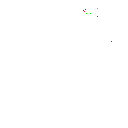
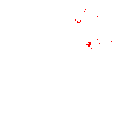
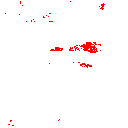
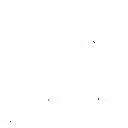

In [11]:
l_anom_np = l_anom.cpu().numpy()
h_anom_np = h_anom.cpu().numpy()

interactive_map = map(minicube)

bounds = [[float(minicube.lat[-1].values), float(minicube.lon[0].values)], [float(minicube.lat[0].values), float(minicube.lon[-1].values)]]

colors = [(0, 0, 0, 0), (1, 0, 0, 1), (0, 1, 0, 1)]   # transparent, R, G
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5], cmap.N)

l_anomal = np.array_split(l_anom_np, 12, axis=0)
h_anomal = np.array_split(h_anom_np, 12, axis=0)

for month_idx, (l_month, h_month) in enumerate(zip(l_anomal, h_anomal)):

    month = np.zeros((l_month.shape[1], l_month.shape[2]))
    month[np.sum(l_month.astype(int), axis=0) > 0] = 1
    month[np.sum(h_month.astype(int), axis=0) > 0] = 2

    colored_anom = cmap(norm(month))

    folium.raster_layers.ImageOverlay(
        image=colored_anom,
        bounds=bounds,
        mercator_project=True,
        name=f"Statistical anomalies in month {month_idx})",
        opacity=0.8,
    ).add_to(interactive_map)


folium.map.LayerControl(position='topright', collapsed=False, autoZIndex=True).add_to(interactive_map)

interactive_map